In [9]:
import numpy as np
from scipy import ndimage, stats, ndimage
import matplotlib.pyplot as plt
from nilearn import plotting, image, input_data
from nilearn.image import load_img, index_img, new_img_like, resample_to_img, threshold_img
from nilearn.input_data import NiftiMasker
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats
import nilearn

%matplotlib inline

In [10]:
import nibabel as nib

# affine transform used from brainmap.org (https://brainmap.org/icbm2tal/)
def icbm_spm2tal(input_mni_image,name):

    icbm_spm2tal_affine = np.array([[0.9254, 0.0024, -0.0118, -1.0207],
                                    [-0.0048, 0.9316, -0.0871, -1.7667],
                                    [0.0152, 0.0883,  0.8924, 4.0926],
                                    [0.0000, 0.0000, 0.0000, 1.0000]]);
        
    # apply affine transform to source affine
    moving_vox2mm = input_mni_image.affine
    new_vox2mm = icbm_spm2tal_affine.dot(moving_vox2mm)  # apply affine transform here
    nib.save(input_mni_image.__class__(input_mni_image.get_data(), 
                                       new_vox2mm, 
                                       input_mni_image.header), 
             'data/shokri_kojori_et_al_2019/' + name + '_tal.nii.gz')
    return_image = load_img('data/shokri_kojori_et_al_2019/' + name + '_tal.nii.gz')
    return return_image

def mean_confidence_interval(data, confidence, voxel_per_resel):
    a = 1.0 * np.array(data)
    voxels = len(a)
    print(len(a))
    m = np.mean(a)
    
    # adjust standard error for resolution elements
    se = np.std(a)/np.sqrt(voxels / voxel_per_resel)
    
    # ppf(q, df) - https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., (voxels/voxel_per_resel) - 1)
    
    return m, m-h, m+h

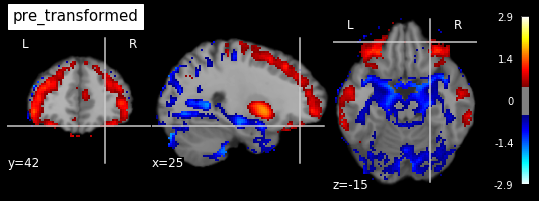

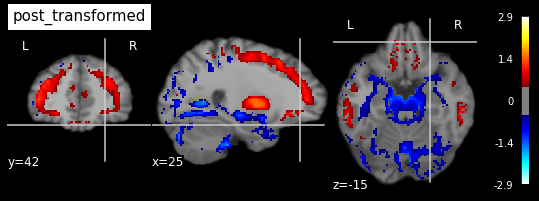

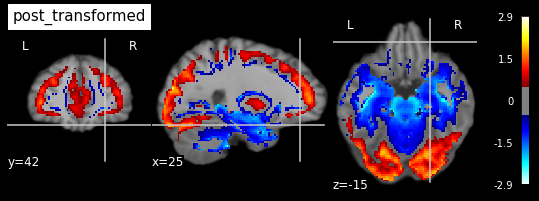

In [11]:
# transform mni metabolic stat maps to talariach space

rCST = image.load_img('data/shokri_kojori_et_al_2019/mean_rCST.nii.gz')
nilearn.plotting.plot_stat_map(rCST, 
                               bg_img='data/colin_27.nii.gz', 
                               cut_coords=(25,42,-15),
                               threshold=0.5,
                               title="pre_transformed")
rCST_tal = icbm_spm2tal(rCST,"mean_rCST")
nilearn.plotting.plot_stat_map(rCST_tal, 
                               bg_img='data/colin_27.nii.gz', 
                               cut_coords=(25,42,-15),
                               threshold=0.5,
                               title="post_transformed")
rPWR = image.load_img('data/shokri_kojori_et_al_2019/mean_rPWR.nii.gz')
rPWR_tal = icbm_spm2tal(rPWR, "mean_rPWR")
nilearn.plotting.plot_stat_map(rPWR_tal, 
                               bg_img='data/colin_27.nii.gz', 
                               cut_coords=(25,42,-15),
                               threshold=0.5,
                               title="post_transformed")

In [12]:
# calculate estimate of voxels per resolution element for confidence calculation

mean_rCST_tal_resample = nilearn.image.resample_to_img(rCST_tal,'data/colin_27_mask_2mm_dil.nii.gz')
mean_rCST_tal_resample.to_filename('data/shokri_kojori_et_al_2019/mean_rCST_tal_resample.nii.gz')

from nipype.interfaces.fsl.model import SmoothEstimate
est = SmoothEstimate()
est.inputs.zstat_file = 'data/shokri_kojori_et_al_2019/mean_rCST_tal_resample.nii.gz'
est.inputs.mask_file = 'data/colin_27_mask_2mm_dil.nii.gz'
est.terminal_output = 'file_split'
smoothest_output = est.run()
print(smoothest_output.outputs)

mean_rPWR_tal_resample = nilearn.image.resample_to_img(rPWR_tal,'data/colin_27_mask_2mm_dil.nii.gz')
mean_rPWR_tal_resample.to_filename('data/shokri_kojori_et_al_2019/mean_rPWR_tal_resample.nii.gz')

est.inputs.zstat_file = 'data/shokri_kojori_et_al_2019/mean_rPWR_tal_resample.nii.gz'
est.inputs.mask_file = 'data/colin_27_mask_2mm_dil.nii.gz'
est.terminal_output = 'file_split'
smoothest_output = est.run()
print(smoothest_output.outputs)


dlh = 0.199042
resels = 23.1944
volume = 201158


dlh = 0.173851
resels = 26.5552
volume = 201158



In [13]:
# mean rCST: 1 resel / 23.19 mm^3 = 1 resel * (1 / 23.19 mm^3) * (2 x 2 x 2 mm^3 / voxel)
print("mean rCST, " + str(23.19/8) + " 2 mm^3 voxels per resel")
voxel_per_resel_rCST = 23.19/8
# mean rPWR: 1 resel / 26.55 mm^3 = 1 resel * (1 / 23.19 mm^3) * (2 x 2 x 2 mm^3 / voxel)
print("mean rPWR, " + str(26.55/8) + " 2 mm^3 voxels per resel")
voxel_per_resel_rPWR = 26.55/8

mean rCST, 2.89875 2 mm^3 voxels per resel
mean rPWR, 3.31875 2 mm^3 voxels per resel


In [14]:
data = pd.read_csv("data/python_entropy_analysis/entropy_correlation_data_75perc.csv") 

z_threshold = 5

for modality in ["FUNCTIONAL", "VBM"]:
    for i in range(1,21):
        print("Network: " + str(i))
        if i < 10:
            image_premask = image.load_img('data/' + modality + '_ICA_BRAINMAP_0' + str(i) + '.nii.gz')
            image_postmask = image.math_img('img_1>' + str(z_threshold),
                                           img_1 = image_premask)
            masker = NiftiMasker(mask_img=image_postmask)
            
            rCST = masker.fit_transform(rCST_tal)
            rCST = rCST[~np.isnan(rCST)]
            # find mean, low and high estimates
            m_rCST, l_rCST, h_rCST = mean_confidence_interval(rCST, 0.99, voxel_per_resel_rCST)
            
            
            rPWR = masker.fit_transform(rPWR_tal)
            rPWR = rPWR[~np.isnan(rPWR)]
            m_rPWR, l_rPWR, h_rPWR = mean_confidence_interval(rPWR, 0.99, voxel_per_resel_rPWR)
            
            if modality == "VBM":
                data.loc[data[data['Comp_Dis'] == ("IC-0" + str(i))].index.tolist(),"CST_minus_PWR_VBM"] = m_rCST-m_rPWR
                data.loc[data[data['Comp_Dis'] == ("IC-0" + str(i))].index.tolist(),"CST_minus_PWR_VBM_ERROR"] = np.sqrt(np.square(h_rCST-l_rCST) + np.square(h_rPWR-l_rPWR))
            else:
                data.loc[data[data['Comp_Behav'] == ("IC-0" + str(i))].index.tolist(),"CST_minus_PWR_FUNC"] = m_rCST-m_rPWR
                data.loc[data[data['Comp_Behav'] == ("IC-0" + str(i))].index.tolist(),"CST_minus_PWR_FUNC_ERROR"] = np.sqrt(np.square(h_rCST-l_rCST) + np.square(h_rPWR-l_rPWR))
                           
        else: 
            image_premask = image.load_img('data/' + modality + '_ICA_BRAINMAP_' + str(i) + '.nii.gz')
            image_postmask = image.math_img('img_1>' + str(z_threshold),
                                           img_1 = image_premask)
            masker = NiftiMasker(mask_img=image_postmask)
            
            rCST = masker.fit_transform(rCST_tal)
            rCST = rCST[~np.isnan(rCST)]
            # find mean, low and high estimates  
            m_rCST, l_rCST, h_rCST = mean_confidence_interval(rCST, 0.99, voxel_per_resel_rCST)
            
            rPWR = masker.fit_transform(rPWR_tal)
            rPWR = rPWR[~np.isnan(rPWR)]
            m_rPWR, l_rPWR, h_rPWR = mean_confidence_interval(rPWR, 0.99, voxel_per_resel_rPWR)
            
            if modality == "VBM":
                data.loc[data[data['Comp_Dis'] == ("IC-" + str(i))].index.tolist(),"CST_minus_PWR_VBM"] = m_rCST - m_rPWR
                data.loc[data[data['Comp_Dis'] == ("IC-" + str(i))].index.tolist(),"CST_minus_PWR_VBM_ERROR"] = np.sqrt(np.square(h_rCST-l_rCST) + np.square(h_rPWR-l_rPWR))
            else:
                data.loc[data[data['Comp_Behav'] == ("IC-" + str(i))].index.tolist(),"CST_minus_PWR_FUNC"] = m_rCST - m_rPWR
                data.loc[data[data['Comp_Behav'] == ("IC-" + str(i))].index.tolist(),"CST_minus_PWR_FUNC_ERROR"] = np.sqrt(np.square(h_rCST-l_rCST) + np.square(h_rPWR-l_rPWR))

# change entropy data from fraction to percentage
data["A.Entropy"] = data["A.Entropy"]*100
data["B.Entropy"] = data["B.Entropy"]*100

Network: 1
17147
17147
Network: 2
19730
19730
Network: 3
15968
15968
Network: 4
7067
7067
Network: 5
12605
12605
Network: 6
6145
6145
Network: 7
12653
12653
Network: 8
15075
15075
Network: 9
16035
16035
Network: 10
14241
14241
Network: 11
14116
14116
Network: 12
15984
15984
Network: 13
19302
19302
Network: 14
8314
8314
Network: 15
14500
14500
Network: 16
6830
6830
Network: 17
24378
24378
Network: 18
16301
16301
Network: 19
16255
16255
Network: 20
26409
26409
Network: 1
5607
5607
Network: 2
6806
6806
Network: 3
7194
7194
Network: 4
6647
6647
Network: 5
4060
4060
Network: 6
3903
3903
Network: 7
17294
17294
Network: 8
11916
11916
Network: 9
13719
13719
Network: 10
11738
11738
Network: 11
10718
10718
Network: 12
7734
7734
Network: 13
6149
6149
Network: 14
10480
10480
Network: 15
3573
3573
Network: 16
9424
9424
Network: 17
5260
5260
Network: 18
9230
9230
Network: 19
18550
18550
Network: 20
11485
11485


    index  Unnamed: 0 Comp_Dis  A.Entropy              Labels  A.Hits  \
0       0           0    IC-01  74.516838      Temporo-Limbic      19   
1       1           1    IC-02  61.125595     Fronto-Striatal      15   
2       2           2    IC-03  70.364848   Ventral Attention      15   
3       3           3    IC-11  53.865935            Auditory       8   
4       4           4    IC-20   0.000000       Medial Visual       0   
5       5           5    IC-09  53.571823   Cognitive Control       8   
6       6           6    IC-12  76.740826            Salience      21   
7       7           7    IC-07  46.567649  R. Cent. Executive       6   
8       8           8    IC-16  71.177500  L. Cent. Executive      16   
9      10          10    IC-15  67.976963         MDN (Thal.)      16   
10     12          12    IC-18  42.178702       Posterior DMN       5   
11     13          13    IC-10  50.499519   Hand Sensorimotor       7   
12     14          14    IC-10  50.499519  Mouth Se

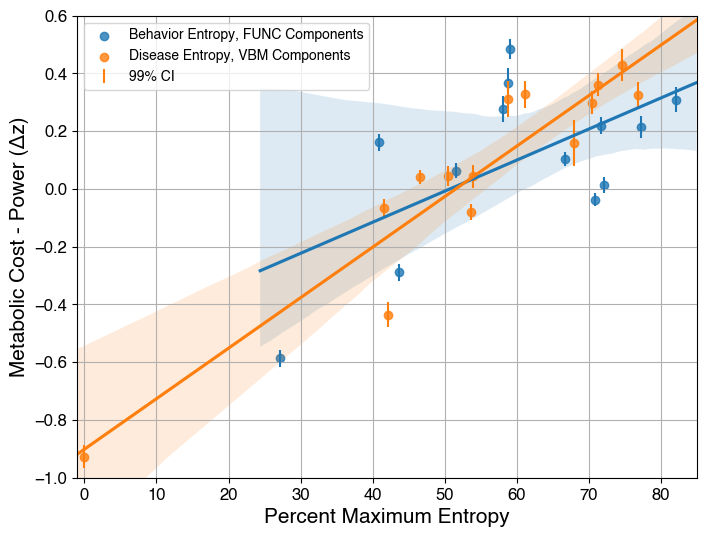

In [20]:
import pylab as pl
import numpy as np

from matplotlib import rc
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


func_df = data.copy()
# drop redundant matches (e.g., anterior/posterior match)
func_df = func_df.drop([9,11], axis=0)
func_df = func_df.reset_index()
print(func_df)

variable_of_interest = "Entropy"

# find python's default colors for coloring error bars
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

g = sns.regplot(x="B." + variable_of_interest, y="CST_minus_PWR_FUNC", data=func_df, label="Behavior Entropy, FUNC Components");
plt.errorbar(func_df["B." + variable_of_interest], 
             func_df["CST_minus_PWR_FUNC"], 
             yerr=func_df["CST_minus_PWR_FUNC_ERROR"]/2, 
             fmt='none',
             ecolor=colors[0])

# add annotations one by one with a loop
# for line in range(0,func_df.shape[0]):
#      g.text(func_df["B.Entropy"][line]+0.2, func_df["CST_minus_PWR_FUNC"][line], func_df["Labels"][line], horizontalalignment='left', size='small', color='black', weight='semibold')

vbm_df = data.copy()
# drop redundant matches
vbm_df = vbm_df.drop(14, axis=0)
vbm_df = vbm_df.reset_index()
print(vbm_df)

g = sns.regplot(x="A." + variable_of_interest, y="CST_minus_PWR_VBM", data=vbm_df, label="Disease Entropy, VBM Components");
plt.errorbar(vbm_df["A." + variable_of_interest], 
             vbm_df["CST_minus_PWR_VBM"], 
             yerr=vbm_df["CST_minus_PWR_VBM_ERROR"]/2, 
             fmt='none',
             label='99% CI',
             ecolor=colors[1])

# add annotations one by one with a loop
# for line in range(0,vbm_df.shape[0]):
#      g.text(vbm_df["A.Entropy"][line]+0.2, vbm_df["CST_minus_PWR_VBM"][line], vbm_df["Labels"][line], horizontalalignment='left', size='small', color='black', weight='semibold')

import scipy
lm_model = scipy.stats.linregress(vbm_df["A." + variable_of_interest], y=vbm_df["CST_minus_PWR_VBM"])
print(lm_model)
plt.legend(loc='upper left')
plt.grid(True)
plt.xlim([-1, 85])
plt.ylim([-1, 0.6])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

g.figure.set_size_inches(8, 6)

from matplotlib.pyplot import figure
g.set_xlabel('Percent Maximum Entropy', fontsize=15)
g.set_ylabel('Metabolic Cost - Power (\u0394z)', fontsize=15)
plt.savefig('figures/figure_4.png',dpi=500)
 
import scipy
lm_model = scipy.stats.linregress(func_df["B." + variable_of_interest], y=func_df["CST_minus_PWR_FUNC"])
print(lm_model)



In [8]:
func_df.to_csv('data/shokri_kojori_et_al_2019/behav_cost.csv')
vbm_df.to_csv('data/shokri_kojori_et_al_2019/vbm_cost.csv')